# Time Series, Stock Price

## Copulas
Copulas capture the dependence structure between random variables without altering their individual behaviors
1. Definition: A copula: $C:[0,1]^2 → [0,1]$ is a multivariate cumulative distribution function (CDF) whose one-dimensional margins are uniform on $[0, 1]$, where $U$ and $V$ are random variables with uniform distributions on $[0, 1]$:
   $$C(u,v)=P(U\le u, V\le v)$$
2. **Sklar**’s Theorem: Every multivariate distribution function can be expressed in terms of its margins and copula. Given a bivariate distribution function $H(x,y)$ with margins $F(x)$ and $G(y)$, there exists a copula $C(u,v)$ such that:
   $$ H(x,y)=C(F(x),G(y))$$
3. kinds of copula:
 - Gaussian Copula: Perhaps the most well-known, the Gaussian copula captures linear dependencies between variables. It derives from the multivariate normal distribution. This copula is often favored for its mathematical simplicity but can underestimate tail dependencies.
- Clayton Copula: This copula is asymmetrical and is particularly useful when modelling lower tail dependence, which means it’s well-suited for scenarios where joint extreme low values are of concern.
- Gumbel Copula: The opposite of the Clayton copula, the Gumbel copula models upper tail dependence. It’s employed when the concern is about joint extreme high values.
 - Frank Copula: This copula does not capture tail dependencies but offers an intermediate dependence structure. It’s useful in scenarios where the tails of distributions are not of primary concern.     
## Reference
1. [copulous](https://medium.com/@crisvelasquez/stock-scenario-modelling-tail-risk-dependence-with-copulas-in-python-25591885366f)

In [17]:
# numerical and statistical utilities
import numpy as np
from scipy import stats
from scipy.stats import norm
from scipy.stats import rankdata

# visualization requirements
import matplotlib.pyplot as plt
import seaborn as sns
#from IPython.display import display,Latex,HTML
#from termcolor import colored

# data utitilies
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import datetime as dt

from copulas.bivariate import Clayton

# system utilities
from tqdm import tqdm
import gc

%matplotlib inline

In [28]:
# 1. Data Collection:
# Definestock basket
stocks = ["2330.TW", "2454.TW", "4908.TWO", "6533.TW","^TWII"]
# Fetch data

# 1. Data Collection:
# Definestock basket
start = dt.datetime(2020, 1, 1).strftime('%Y-%m-%d')
#end   = dt.datetime(2023, 2, 9).strftime('%Y-%m-%d')
end =  dt.date.today()

data = yf.download(stocks, start=start, end=end)['Adj Close']

[*********************100%%**********************]  5 of 5 completed


In [29]:
data

,2330.TW,2454.TW,4908.TWO,6533.TW,^TWII
Date,,,,,
2020-01-02,310.429138,333.562134,34.671497,131.221664,12100.480469
2020-01-03,310.886993,328.273499,33.120296,126.798470,12110.429688
2020-01-06,304.019073,320.340546,33.539539,126.798470,11953.360352
2020-01-07,301.729797,321.851593,32.868748,123.849663,11880.320312
2020-01-08,301.729797,325.251434,32.701050,123.358208,11817.099609
...,...,...,...,...,...
2024-01-23,628.000000,911.000000,89.099998,493.000000,17874.589844
2024-01-24,627.000000,936.000000,87.199997,482.000000,17875.830078
2024-01-25,642.000000,943.000000,85.599998,478.000000,18002.619141


In [30]:
# 2. Data Preprocessing:
# Compute daily returns and drop NaN values
returns = data.pct_change().dropna()

In [31]:
# Convert data to uniform using ECDF
def to_uniform(column):
    n = len(column)
    return rankdata(column) / (n + 1)

uniform_data = returns.apply(to_uniform)
uniform_data

,2330.TW,2454.TW,4908.TWO,6533.TW,^TWII
Date,,,,,
2020-01-03,0.519637,0.192346,0.050352,0.130916,0.499496
2020-01-06,0.077543,0.111782,0.729104,0.492447,0.092649
2020-01-07,0.290030,0.602216,0.163142,0.213494,0.232628
2020-01-08,0.492447,0.705942,0.389728,0.444109,0.253776
2020-01-09,0.930514,0.769386,0.858510,0.731118,0.903323
...,...,...,...,...,...
2024-01-23,0.563948,0.257805,0.711984,0.646526,0.615307
2024-01-24,0.457200,0.873112,0.155086,0.228600,0.458207
2024-01-25,0.928499,0.657603,0.179255,0.403827,0.757301


In [32]:
# 3. Rolling Time Window Analysis:
# Rolling window analysis
window_size = 250
tail_parameters = []

for start in range(0, len(uniform_data) - window_size):
    window_data = uniform_data.iloc[start:start + window_size]
    
    copula = Clayton()
    copula.fit(window_data.values)
    
    # Extract tail parameter (for Clayton, the theta parameter)
    tail_parameters.append(copula.theta)

/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/copulas/bivariate/base.py:162: RuntimeWarning: Data does not appear to be uniform.
  warnings.warn('Data does not appear to be uniform.', category=RuntimeWarning)


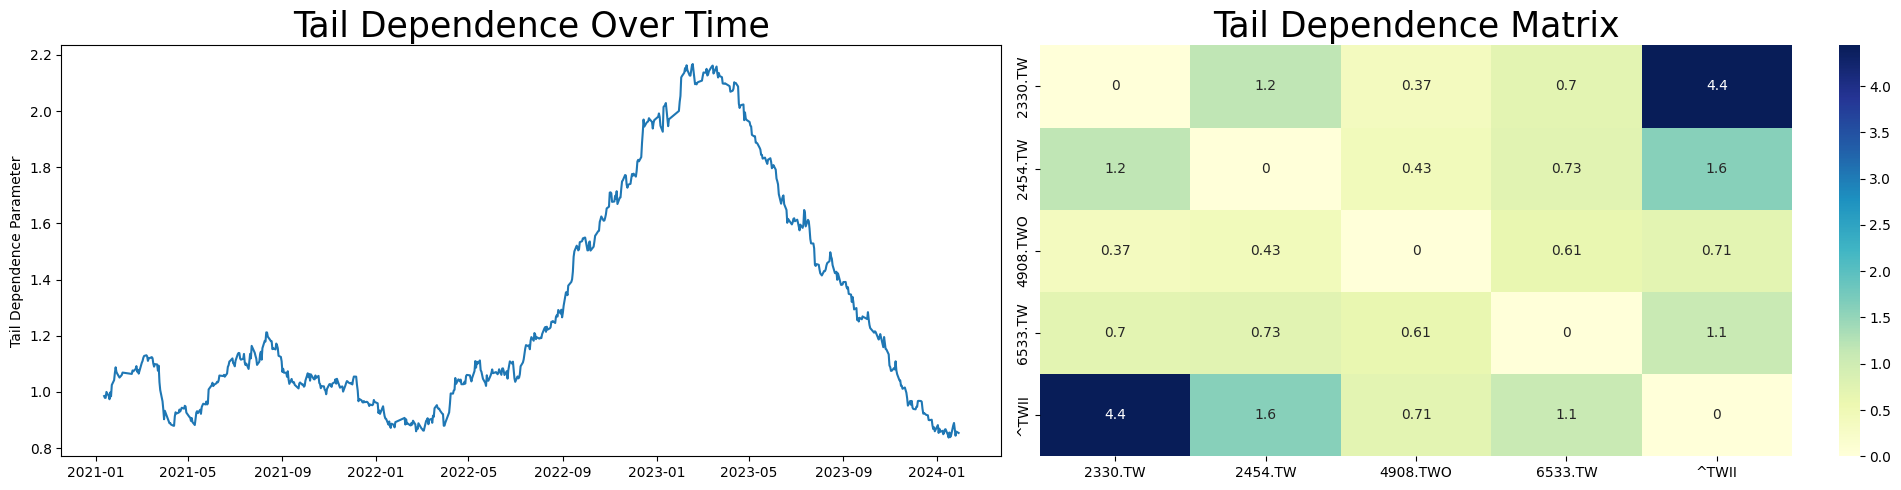

In [34]:
# 4. Visualization:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))  # 1 row, 2 columns

# Plotting the Tail Dependence Over Time on the first subplot
ax1.plot(returns.index[window_size:], tail_parameters)
ax1.set_title('Tail Dependence Over Time',fontsize=25)
ax1.set_ylabel('Tail Dependence Parameter')

# Constructing the Tail Dependence Matrix
tail_dep_matrix = np.zeros((len(stocks), len(stocks)))
for i in range(len(stocks)):
    for j in range(len(stocks)):
        if i != j:
            copula_ij = Clayton()
            copula_ij.fit(uniform_data[[stocks[i], stocks[j]]].values)
            tail_dep_matrix[i, j] = copula_ij.theta
# Plotting the heatmap on the second subplot
sns.heatmap(tail_dep_matrix, annot=True, cmap='YlGnBu', xticklabels=stocks, yticklabels=stocks, ax=ax2)
ax2.set_title("Tail Dependence Matrix", fontsize=25)

plt.tight_layout()  
plt.show()

**Above**,Visual Analysis of Tail Dependence among Selected Stocks: T
1. he left graph reveals the rolling tail dependence over time, highlighting periods with heightened joint extreme behavior.
2. The right heatmap provides a pairwise tail dependence matrix, offering insights into which pairs of assets exhibit stronger extreme co-movements. Particularly, the intensity of colors in the heatmap denotes the strength of tail dependence between asset pairs, with darker shades indicating stronger dependence.

Chis means, TWII is heavily dependent on **TSMC**.

## The Power of Copulas in Financial Analysis
### Why copulas offer a superior approach for scenario modelling
Copulas stand out because they allow for the examination of individual asset behaviors (through their marginals) and their interrelationships (through the copula itself). This duality makes them perfect for scenario modelling, capturing nuanced relationships beyond mere correlation.

### Insights derived from applying copulas and tail dependencies
From our analysis, observing the evolution of tail dependencies over time can provide crucial insights into how the dependency structure shifts during market events. A rising tail dependence parameter, for instance, might indicate increasing concurrence of extreme losses in assets, signaling a red flag for diversified portfolios.

### Real-world implications of using copulas
For portfolio managers, understanding tail dependencies means better risk management. If two assets tend to suffer extreme losses together, diversifying across them may offer limited risk reduction. Copulas, thus, can guide better asset allocation, hedging strategies, and stress-testing exercises.



## Limitations and Criticisms of Using Copulas
While copulas offer robust tools for financial modelling, they aren’t without challenges:

- Misspecification Risk: The choice of copula matters. Using an incorrect copula can lead to misleading results.
- Static Nature: While rolling windows capture evolving dependencies, copulas themselves don’t inherently model changing relationships over time.
- Data Sensitivity: Small changes in input data might lead to significant shifts in the copula parameter estimates.